Epoch: 0 cost:  2.3035119746770882 accuracy:  0.9
Epoch: 50 cost:  1.1225717139692066 accuracy:  0.9241033333333334
Epoch: 100 cost:  0.7985984334460512 accuracy:  0.9464383333333334
Epoch: 150 cost:  0.6663843981581954 accuracy:  0.9535966666666666
Epoch: 200 cost:  0.591397302815046 accuracy:  0.9593733333333333
Epoch: 250 cost:  0.5847778987358685 accuracy:  0.9580033333333333
Epoch: 300 cost:  0.5419873732043381 accuracy:  0.9619733333333333
Epoch: 350 cost:  0.5130659142699087 accuracy:  0.9646166666666667
Epoch: 400 cost:  0.49527500145901926 accuracy:  0.9648983333333333
Epoch: 450 cost:  0.5118813773541215 accuracy:  0.9642133333333334

 CALCULATED VALUE OF ACCURACY, PRECISION AND RECALL ON TEST DATA FOR FASHION-MNIST DATASET
------------------------------------------------------------------------------------------
ACCURACY VALUE: 0.9656
PRECISION VALUE: 0.9859
RECALL VALUE: 0.9761171371366967






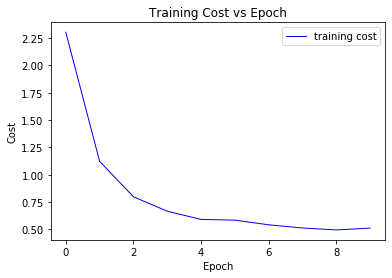

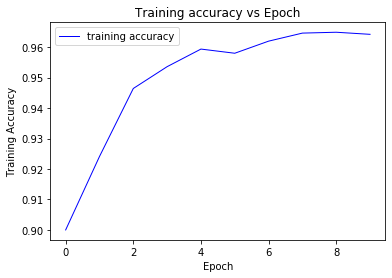

In [6]:
'''
Implementing a basic Neural Network Model from scratch with one hidden layer

'''
import copy
import numpy as np
import keras
import tensorflow as tf
import sklearn
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import util_mnist_reader

np.seterr(divide='ignore', invalid='ignore')

# Loss Function for calculating the loss
def compute_multiclass_loss(Y, Y_hat):
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1.0 / m) * L_sum
    return L

# Sigmoid Function for the inner layers
def sigmoid(z):
    s = 1.0 / (1.0 + np.exp(-z))
    return s

# Softmax Function for the output layer
def softmax(A):
    expA = np.exp(A)
    return expA / np.sum(expA, axis=0)

# Method for generating a label from the predicted output
def build_pred_list(Y_list):
    y_pred = copy.deepcopy(Y_list)

    for i in range(len(y_pred)):
        for j in range(len(y_pred[0])):
            if Y_list[i][j] >= 0.5:
                y_pred[i][j] = 1.0
            else:
                y_pred[i][j] = 0.0
    return y_pred

# Generating the confusion matrix for computing the accuracy of the model
def build_confusion_matrix(Y_true,Y_pred):
    matrix = multilabel_confusion_matrix(Y_true,Y_pred)
    #print(matrix)
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    for i in range(len(matrix)):
        TP += matrix[i][0][0]
        FP += matrix[i][0][1]
        FN += matrix[i][1][0]
        TN += matrix[i][1][1]
    return TP,FP,FN,TN

# Read Fashion MNIST dataset using Keras
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test,y_test) = fashion_mnist.load_data()
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

# Normalizing the input for training and test data set
X_train = (X_train / 255)
X_test = (X_test / 255)

# taking the transpose of input for easier computation
X_train = X_train.T
X_test = X_test.T

# mapping original output to 1 for training dataset using one_hot labelling
one_hot_labels_train = np.zeros((60000, 10))
for i in range(60000):
    one_hot_labels_train[i, y_train[i]] = 1
    
Y_train = one_hot_labels_train
Y_train = Y_train.T

# mapping original output to 1 for test dataset using one_hot labelling
one_hot_labels_test = np.zeros((10000, 10))
for i in range(10000):
    one_hot_labels_test[i, y_test[i]] = 1

Y_test = one_hot_labels_test
Y_test = Y_test.T

n_x = X_train.shape[0]
n_y = Y_train.shape[0]
#number of hidden nodes
n_h = 32
learning_rate = 0.9

'''
Implementing Feedforward Backward Propagation model
'''
#initializing weights and biases
W1 = np.random.randn(n_h, n_x)*0.01
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(n_y, n_h)*0.01
b2 = np.zeros((n_y, 1))

X = X_train
Y = Y_train
m = X.shape[1]
cost_array = []
accuracy_array = []
epochs = 500

# Training the model
for i in range(epochs):

    # Forward propagation
    Z1 = np.matmul(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2, A1) + b2
    A2 = softmax(Z2)

    cost = compute_multiclass_loss(Y, A2)

    # Backpropagation
    dZ2 = A2 - Y
    dW2 = (1. / m) * np.matmul(dZ2, A1.T)
    db2 = (1. / m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    dW1 = (1. / m) * np.matmul(dZ1, X.T)
    db1 = (1. / m) * np.sum(dZ1, axis=1, keepdims=True)

    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1

    Z1_train = np.matmul(W1, X) + b1
    A1_train = sigmoid(Z1_train)
    Z2_train = np.matmul(W2, A1_train) + b2
    A2_train = softmax(Z2_train)
   
    # Computing the loss and accuracy for every 50th epoch
    if i % 50 == 0:
        # Calculating cost
        cost_array.append(cost)
        train_pred = build_pred_list(A2_train)
        TP,FP,FN,TN = build_confusion_matrix(Y,train_pred)
        # Calculating accuracy
        accuracy_train = (TP+TN)/(TP+FP+FN+TN)
        accuracy_array.append(accuracy_train)
        print("Epoch:", i, "cost: ", cost, "accuracy: ", accuracy_train)

# Calculating Accuracy on testing data set
Z1_test = np.matmul(W1, X_test) + b1
A1_test = sigmoid(Z1_test)
Z2_test = np.matmul(W2,A1_test) + b2
A2_test = softmax(Z2_test)
y_pred = build_pred_list(A2_test)
TP,FP,FN,TN = build_confusion_matrix(Y_test,y_pred)
print('\n CALCULATED VALUE OF ACCURACY, PRECISION AND RECALL ON TEST DATA FOR FASHION-MNIST DATASET')
print('------------------------------------------------------------------------------------------')

accuracy_test = (TP+TN)/(TP+TN+FP+FN)
print('ACCURACY VALUE: ' +str(accuracy_test))

precision_test = TP/(TP+FP)
print('PRECISION VALUE: ' +str(precision_test))

recall_test = TP/(TP+FN)
print('RECALL VALUE: '+str(recall_test))
print('\n')
print('\n')

plt.title('Training Cost vs Epoch')  
plt.plot(cost_array,color = 'blue', label ='training cost',lw=1)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend(loc = 'best')
plt.show()

plt.title('Training accuracy vs Epoch')  
plt.plot(accuracy_array,color = 'blue', label ='training accuracy',lw=1)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend(loc = 'best')
plt.show()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_51 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_52 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 36us/step - loss: 2.2575 - accuracy: 0.2836 - val_loss: 2.1855 - val_accuracy: 0.4498
Epoch 2/200
60000/60000 [======================

Epoch 50/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.4839 - accuracy: 0.8278 - val_loss: 0.5098 - val_accuracy: 0.8149
Epoch 51/200
60000/60000 [==============================] - 2s 31us/step - loss: 0.4812 - accuracy: 0.8286 - val_loss: 0.5075 - val_accuracy: 0.8153
Epoch 52/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.4786 - accuracy: 0.8302 - val_loss: 0.5052 - val_accuracy: 0.8164
Epoch 53/200
60000/60000 [==============================] - 2s 37us/step - loss: 0.4761 - accuracy: 0.8309 - val_loss: 0.5028 - val_accuracy: 0.8161
Epoch 54/200
60000/60000 [==============================] - 2s 32us/step - loss: 0.4736 - accuracy: 0.8319 - val_loss: 0.5011 - val_accuracy: 0.8166
Epoch 55/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.4714 - accuracy: 0.8321 - val_loss: 0.4989 - val_accuracy: 0.8189
Epoch 56/200
60000/60000 [==============================] - 2s 33us/step - loss: 0.4691 - accuracy: 0.8331

Epoch 105/200
60000/60000 [==============================] - 3s 43us/step - loss: 0.4028 - accuracy: 0.8565 - val_loss: 0.4401 - val_accuracy: 0.8414
Epoch 106/200
60000/60000 [==============================] - 2s 28us/step - loss: 0.4019 - accuracy: 0.8566 - val_loss: 0.4400 - val_accuracy: 0.8416
Epoch 107/200
60000/60000 [==============================] - 1s 23us/step - loss: 0.4011 - accuracy: 0.8569 - val_loss: 0.4394 - val_accuracy: 0.8410
Epoch 108/200
60000/60000 [==============================] - 2s 38us/step - loss: 0.4001 - accuracy: 0.8570 - val_loss: 0.4387 - val_accuracy: 0.8419
Epoch 109/200
60000/60000 [==============================] - 2s 30us/step - loss: 0.3993 - accuracy: 0.8577 - val_loss: 0.4377 - val_accuracy: 0.8416
Epoch 110/200
60000/60000 [==============================] - 1s 22us/step - loss: 0.3983 - accuracy: 0.8578 - val_loss: 0.4366 - val_accuracy: 0.8431
Epoch 111/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.3976 - accuracy:

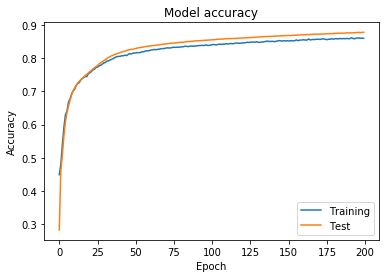

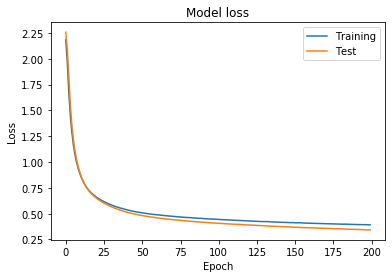

In [26]:
'''
Implementing Multi-Layer Neural Network using Keras

'''

import numpy as np
import mnist
import util_mnist_reader
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

# Read Fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train, Y_train), (X_test,Y_test) = fashion_mnist.load_data()

# Normalizing the train and test dataset
X_train = (X_train / 255.0)
X_test = (X_test / 255.0)

# Modelling a simple multilayer neural network using keras
model = keras.Sequential([
   keras.layers.Flatten(input_shape=(28,28)),
   keras.layers.Dense(128, activation=tf.nn.sigmoid),
   keras.layers.Dense(128, activation=tf.nn.sigmoid),
   keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Print model summary 
model.summary()

# Compiling the model
model.compile(optimizer='sgd',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# Model fitting
history = model.fit(X_train, Y_train, epochs=200, batch_size = 100, validation_data=[X_test, Y_test])

# Evaluating the loss and accuracy based on test dataset
test_loss, test_acc = model.evaluate(X_test, Y_test)

print('\n CALCULATED VALUE OF ACCURACY AND LOSS ON TEST DATA FOR MULTI LAYER NEURAL NETWORK')
print('------------------------------------------------------------------------------------')
print('TEST LOSS:' +str(test_loss))
print('TEST ACCURACY: '+str(test_acc))

# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Test'], loc='upper right')
plt.show()

In [ ]:
'''
Implementing a Convolutional Neural Network using Keras

'''
import numpy as np
import mnist
import util_mnist_reader
import keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

# Reading the Fashion MNIST dataset and splitting the data into train and test sets
fashion_mnist = keras.datasets.fashion_mnist
(X_train, Y_train), (X_test,Y_test) = fashion_mnist.load_data()

# Data preprocessing - reshaping data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# One-hot encoding for target column
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# Creating the Model
cnn_model = Sequential()

# Adding more layers
cnn_model.add(Conv2D(64, kernel_size=2, activation='sigmoid', input_shape=(28,28,1)))
cnn_model.add(Conv2D(32, kernel_size=2, activation='sigmoid'))
cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='softmax'))

# Compiling the model using accuracy as the metrics and Stochastic Gradient Descent as optimizer
cnn_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = cnn_model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=50)

# Evaluating the loss and accuracy based on the test dataset
test_loss, test_acc = cnn_model.evaluate(X_test, Y_test)

print('\n CALCULATED VALUE OF ACCURACY AND LOSS ON TEST DATA FOR CONVOLUTIONAL NEURAL NETWORK')
print('---------------------------------------------------------------------------------------')
print('CNN MODEL TEST_DATA LOSS:' +str(test_loss))
print('CNN MODEL TEST_DATA ACCURACY: '+str(test_acc))

# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy for CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss for CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Test'], loc='upper right')
plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 9056/60000 [===>..........................] - ETA: 1:11 - loss: 1.3127 - accuracy: 0.6233